In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from math import sqrt
import seaborn as sns
sns.set()

#Importing the Data and Pre-processing

In [13]:
raw_csv_data = pd.read_csv('Index2018.csv')
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True) # Convertir la columna date a datetime
df_comp.set_index('date', inplace=True) # Establecer la columna date como índice
df_comp = df_comp.asfreq('b') # Frecuencia de negociación de acciones
df_comp = df_comp.ffill() # Rellenar los valores faltantes con el método forward fill

In [14]:
df_comp.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [15]:
df_comp['market_value'] = df_comp.ftse

In [16]:
del df_comp['spx']
del df_comp['dax']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

# The LLR test (Diferencia de log-likelihood)

In [ ]:
# Prueba de hipótesis para el modelo MA(p) vs MA(p+1), prueba de razón de verosimilitud
def LLR_test(mod_1, mod_2, DF = 1): # DF = 1 porque es un test de diferencia de log-likelihood para un solo parámetro
    L1 = mod_1.llf # Log-likelihood del modelo 1
    L2 = mod_2.llf # Log-likelihood del modelo 2
    LR = (2*(L2-L1)) # Diferencia de log-likelihood
    p = chi2.sf(LR, DF).round(3) # Probabilidad de que la diferencia sea significativa
    return p

# Creating returns

- Los retornos los creamos para obtener una seríe estacionaría.

In [18]:
df['returns'] = df.market_value.pct_change(1)*100 # Calcular los retornos, pct_change(1) es el retorno diario

C:\Users\grego\AppData\Local\Temp\ipykernel_18592\3774374242.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns'] = df.market_value.pct_change(1)*100 # Calcular los retornos, pct_change(1) es el retorno diario


#ACF for returns

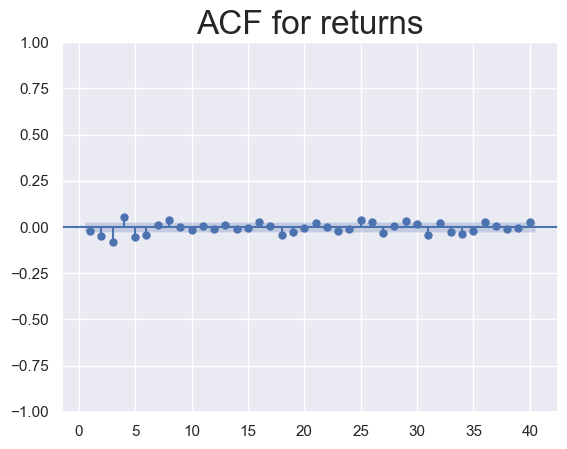

In [20]:
sgt.plot_acf(df.returns[1:], zero=False, lags=40) # Autocorrelación de los retornos, zero=False para que no se incluya el lag 0, lags=40 para que se incluyan los primeros 40 lags.
plt.title('ACF for returns', size=24)
plt.show()

La mayoría de los coeficientes para los primeros retornos son negativos, esto apunta a que en una tendencía los valores consecutivos se mueven en diferentes direcciones, los retornos de una semana son relevantes para los del día actual.

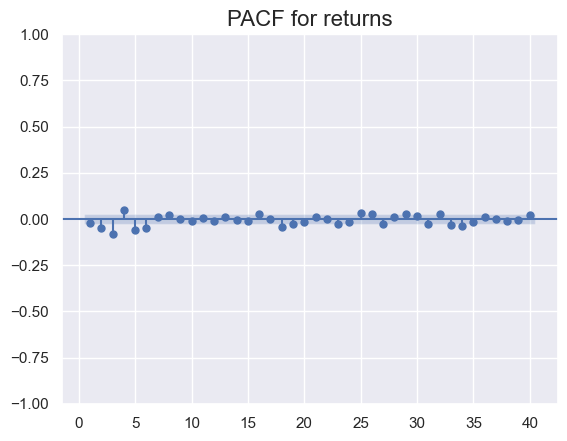

In [22]:
sgt.plot_pacf(df.returns[1:], zero=False, lags=40, method='ols') # Autocorrelación parcial de los retornos, zero=False para que no se incluya el lag 0, lags=40 para que se incluyan los primeros 40 lags.
plt.title('PACF for returns', size=16)
plt.show()

Como vemos, las graficas son similares, podemos intepretar que los precios de hoy a menudo se mueven en dirección opuesta a los precios de ayer. La mayoría de los efectos estan cubiertos en los primeros 6 retrazos.

# MA(1) for returns

In [30]:
#model_ret_ma_1 = ARMA(df.returns[1:], order=(0,1))
model_ret_ma_1 = ARIMA(df.returns[1:], order=(0,0,1)) # ARIMA(0,0,1) es un modelo MA(1)
results_ret_ma_1 = model_ret_ma_1.fit()
results_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -7929.595
Date:                Mon, 14 Jul 2025   AIC                          15865.190
Time:                        02:02:00   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.146      0.252      -0.013       0.051
ma.L1         -0.0257      0.009     -3.018      0.003      -0.042      -0.009
sigma2         1.3789      0.014     99.990      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7852.85
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Como podemos observar en la información de nuestro resumen, podemos inferir que la constante no es significativa para nuestros datos, el valor de nuestro coeficiente podemos inferir que es significativamente distinto de cero.

# Higher-Lag MA Models for returns

In [37]:
model_ret_ma_2 = ARIMA(df.returns[1:], order=(0,0,2))
results_ret_ma_2 = model_ret_ma_2.fit()
print(results_ret_ma_2.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_1, results_ret_ma_2)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -7922.864
Date:                Mon, 14 Jul 2025   AIC                          15853.728
Time:                        02:10:33   BIC                          15879.812
Sample:                    01-10-1994   HQIC                         15862.868
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.204      0.228      -0.012       0.049
ma.L1         -0.0327      0.009     -3.760      0.000      -0.050      -0.016
ma.L2         -0.0502      0.008     -6.416      0.0

In [38]:
model_ret_ma_3 = ARIMA(df.returns[1:], order=(0,0,3))
results_ret_ma_3 = model_ret_ma_3.fit()
print(results_ret_ma_3.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_2, results_ret_ma_3)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -7904.317
Date:                Mon, 14 Jul 2025   AIC                          15818.634
Time:                        02:10:50   BIC                          15851.240
Sample:                    01-10-1994   HQIC                         15830.060
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.296      0.195      -0.010       0.048
ma.L1         -0.0203      0.009     -2.334      0.020      -0.037      -0.003
ma.L2         -0.0556      0.008     -7.032      0.0

In [39]:
model_ret_ma_4 = ARIMA(df.returns[1:], order=(0,0,4))
results_ret_ma_4 = model_ret_ma_4.fit()
print(results_ret_ma_4.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_3, results_ret_ma_4)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -7898.773
Date:                Mon, 14 Jul 2025   AIC                          15809.547
Time:                        02:11:33   BIC                          15848.674
Sample:                    01-10-1994   HQIC                         15823.257
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.236      0.217      -0.011       0.049
ma.L1         -0.0203      0.009     -2.239      0.025      -0.038      -0.003
ma.L2         -0.0551      0.008     -6.835      0.0

In [40]:
model_ret_ma_5 = ARIMA(df.returns[1:], order=(0,0,5))
results_ret_ma_5 = model_ret_ma_5.fit()
print(results_ret_ma_5.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_4, results_ret_ma_5)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 5)   Log Likelihood               -7892.823
Date:                Mon, 14 Jul 2025   AIC                          15799.645
Time:                        02:12:11   BIC                          15845.294
Sample:                    01-10-1994   HQIC                         15815.641
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.282      0.200      -0.010       0.048
ma.L1         -0.0262      0.009     -2.839      0.005      -0.044      -0.008
ma.L2         -0.0497      0.008     -6.147      0.0

In [41]:
model_ret_ma_6 = ARIMA(df.returns[1:], order=(0,0,6))
results_ret_ma_6 = model_ret_ma_6.fit()
print(results_ret_ma_6.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_5, results_ret_ma_6)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -7889.221
Date:                Mon, 14 Jul 2025   AIC                          15794.442
Time:                        02:13:25   BIC                          15846.612
Sample:                    01-10-1994   HQIC                         15812.723
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.318      0.188      -0.009       0.047
ma.L1         -0.0237      0.009     -2.562      0.010      -0.042      -0.006
ma.L2         -0.0486      0.008     -5.982      0.0

In [42]:
model_ret_ma_7 = ARIMA(df.returns[1:], order=(0,0,7))
results_ret_ma_7 = model_ret_ma_7.fit()
print(results_ret_ma_7.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_6, results_ret_ma_7)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -7889.046
Date:                Mon, 14 Jul 2025   AIC                          15796.091
Time:                        02:14:19   BIC                          15854.782
Sample:                    01-10-1994   HQIC                         15816.657
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.303      0.193      -0.010       0.047
ma.L1         -0.0247      0.009     -2.645      0.008      -0.043      -0.006
ma.L2         -0.0488      0.008     -6.000      0.0

In [43]:
model_ret_ma_8 = ARIMA(df.returns[1:], order=(0,0,8))
results_ret_ma_8 = model_ret_ma_8.fit()
print(results_ret_ma_8.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_7, results_ret_ma_8)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 8)   Log Likelihood               -7885.603
Date:                Mon, 14 Jul 2025   AIC                          15791.205
Time:                        02:15:21   BIC                          15856.417
Sample:                    01-10-1994   HQIC                         15814.056
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.253      0.210      -0.011       0.048
ma.L1         -0.0238      0.009     -2.527      0.011      -0.042      -0.005
ma.L2         -0.0495      0.008     -6.053      0.0

In [45]:
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_6, results_ret_ma_8, DF=2)))


LLR test p-value = 0.027


Como podemos observar hasta el modelo de orden 6, tenemos que este ultimo modelo es significativo.

# Residual for returns

In [52]:
#df['res_ret_ma_8'] = results_ret_ma_8.resid[1:]
df.loc[df.index[1:], 'res_ret_ma_8'] = results_ret_ma_8.resid[1:]

In [54]:
print("The mean of the residuals is: " + str(round(df.res_ret_ma_8.mean(), 3)) + "\nThe variance of the residuals is: " + str(round(df.res_ret_ma_8.var(), 3)) )

The mean of the residuals is: -0.0
The variance of the residuals is: 1.356


- La media tiende a cero
- La varianza es 1.356, es decir las desvisciones al cuadrado.

In [56]:
round(sqrt(df.res_ret_ma_8.var()), 3)

1.164

Sabemos que un ruido blanco gauciano implica normalidad, nos intereza comparar los residuos con ruido blanco.
- Aplicaremos la regla de 68, 95 y 99.7 que indica que porcentaje de los datos se propaga a una, dos o tres desviaciones lejos de la media en ambas direcciones, por lo que esperamos que la mayoría de los reciduos de retorno este en el intervalo $ (-3\sigma, 3\sigma) = (-3.492, 3.492) $. Nuestros errores estaran alrededor de unos 7 puntos porcentuales.

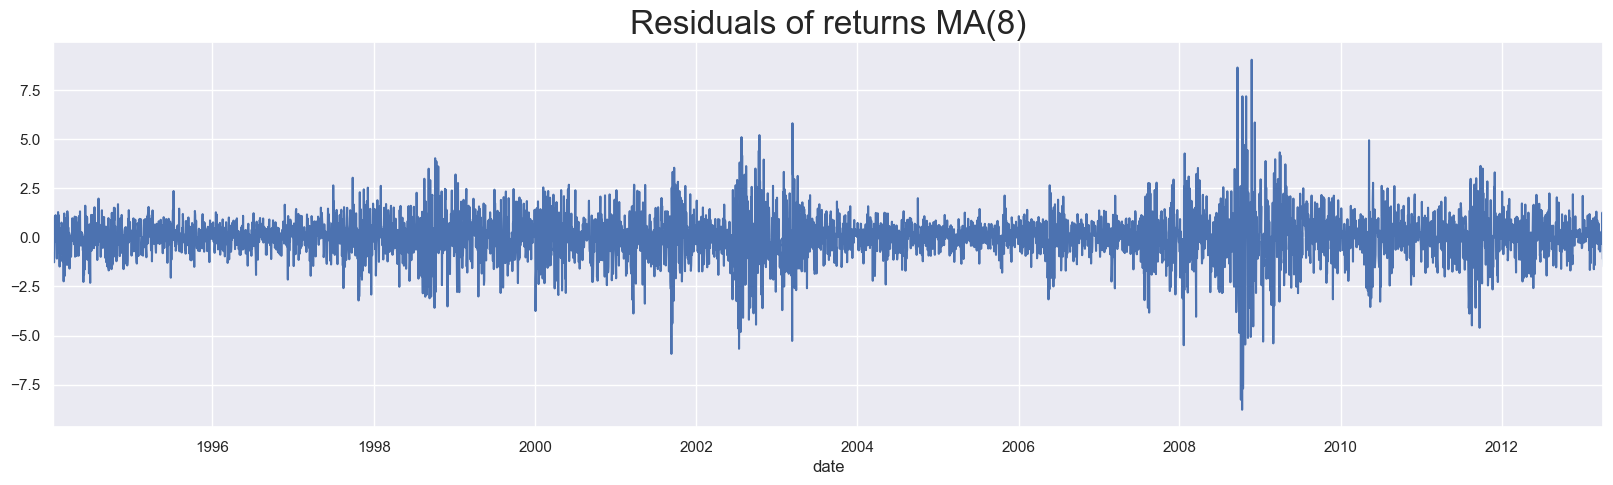

In [57]:
df.res_ret_ma_8[1:].plot(figsize=(20,5))
plt.title('Residuals of returns MA(8)', size=24)
plt.show()


In [59]:
sts.adfuller(df.res_ret_ma_8[2:]) # Test de Dickey-Fuller aumentado para los residuos de MA(8)

(np.float64(-70.8353712559025),
 0.0,
 0,
 5018,
 {'1%': np.float64(-3.4316538358533277),
  '5%': np.float64(-2.8621161549128313),
  '10%': np.float64(-2.567076687880585)},
 np.float64(15684.052217389468))

Del test de Dickey-Fuller podemos observar que, que los datos son estacionarios, observando nuestro $p$ valor. Lo que no significa necesariamente que sea ruido blanco. Comprobemos ahora las funciones de correlación para nuestro residuo.

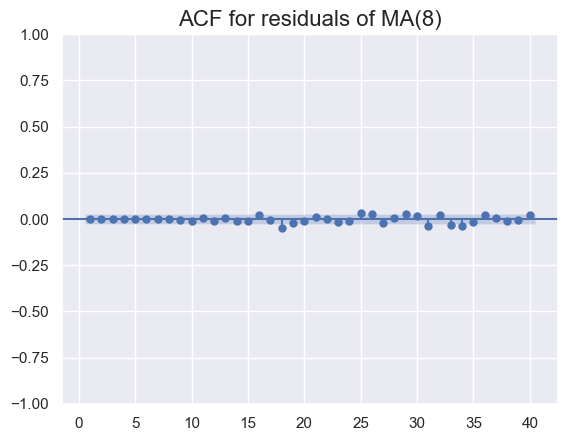

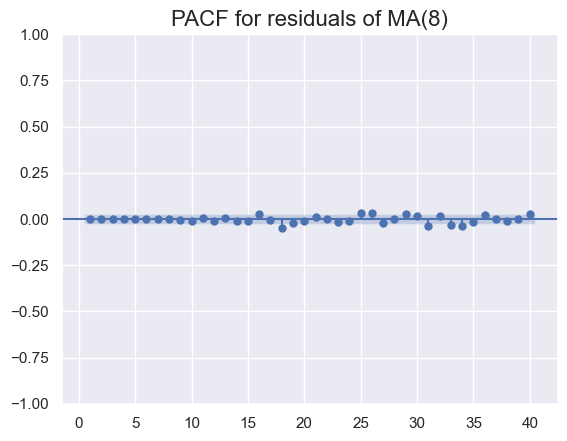

In [60]:
sgt.plot_acf(df.res_ret_ma_8[2:], zero=False, lags=40)
plt.title('ACF for residuals of MA(8)', size=16)
plt.show()

sgt.plot_pacf(df.res_ret_ma_8[2:], zero=False, lags=40)
plt.title('PACF for residuals of MA(8)', size=16)
plt.show()



Como vemos de las funciones de autocorrelación la mayoría de los coeficientes es significativo, y los primeros coeficientes no son significativos, salvo algunos que son significativos, pero segun nuestro modelo y la relevancia en el futuro de los valores del mercado,  estos valores pierden relevancia.

#Tarea para los residuos de MA(6)

- Crea el modelo de medias móviles con 6 retrasos MA(6) para los datos de Retornos. Y analiza su resumen estadístico.

In [61]:
model_ret_ma_6 = ARIMA(df.returns[1:], order=(0,0,6))
results_ret_ma_6 = model_ret_ma_6.fit()
print(results_ret_ma_6.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_5, results_ret_ma_6)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -7889.221
Date:                Mon, 14 Jul 2025   AIC                          15794.442
Time:                        02:45:06   BIC                          15846.612
Sample:                    01-10-1994   HQIC                         15812.723
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.318      0.188      -0.009       0.047
ma.L1         -0.0237      0.009     -2.562      0.010      -0.042      -0.006
ma.L2         -0.0486      0.008     -5.982      0.0

Con un nivel de significación $<0.05$ podemos decir que los coeficientes del 1 al 6 son significativamente distintos de cero y la constante no lo es.

- Guarda los residuos del modelo y dibújalos en un gráfico. ¿Qué se observa?

The mean of the residuals is: -0.0
The variance of the residuals is: 1.357
The standard deviation of the residuals is: 1.165


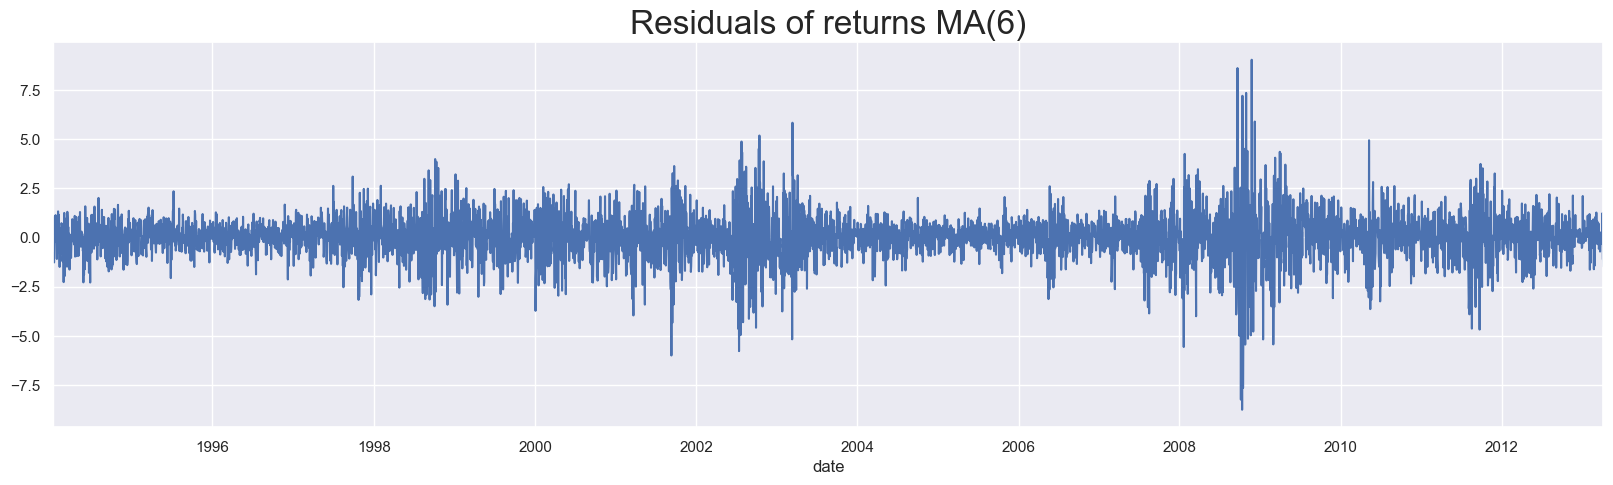

In [63]:
#df['res_ret_ma_8'] = results_ret_ma_8.resid[1:]
df.loc[df.index[1:], 'res_ret_ma_6'] = results_ret_ma_6.resid[1:]
print("The mean of the residuals is: " + str(round(df.res_ret_ma_6.mean(), 3)) + "\nThe variance of the residuals is: " + str(round(df.res_ret_ma_6.var(), 3)) )
print("The standard deviation of the residuals is: " + str(round(sqrt(df.res_ret_ma_6.var()), 3)))
df.res_ret_ma_6[1:].plot(figsize=(20,5))
plt.title('Residuals of returns MA(6)', size=24)
plt.show()

Comparando con el modelo MA(8), no se aprecia un cambio muy significativo en ambos residuos, con relación a su grafico, la media y la desviación estandar.

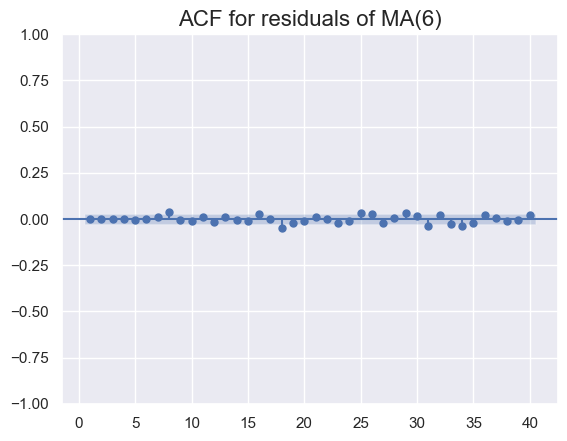

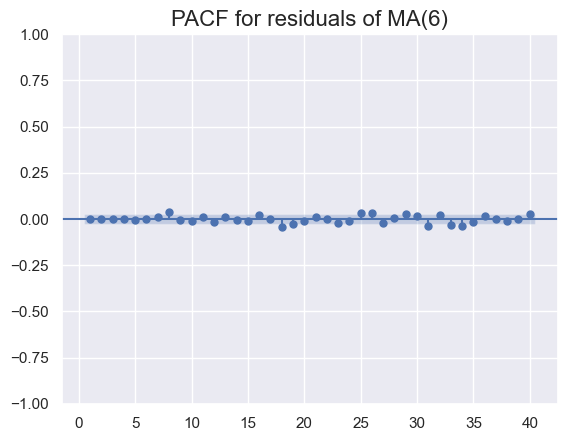

In [64]:
sgt.plot_acf(df.res_ret_ma_6[2:], zero=False, lags=40)
plt.title('ACF for residuals of MA(6)', size=16)
plt.show()

sgt.plot_pacf(df.res_ret_ma_6[2:], zero=False, lags=40)
plt.title('PACF for residuals of MA(6)', size=16)
plt.show()


- Analiza la funcion ACF de los residuos del modelo MA(6) e interpreta los resultados.
Podemos observar de la ACF y PACF que la mayoria de los retornos son significativos, ademas los primeros 7 lo son, lo cuan nos indica para nuestro modelo que es bueno, considerando los retornos en precios del mercado, sin embargo hay un porcentaje considerable de valores no significativos.

Haz un test de estacionariedad de los residuos e interpreta los resultados.

In [66]:
sts.adfuller(df.res_ret_ma_6[2:])

(np.float64(-70.83908082567434),
 0.0,
 0,
 5018,
 {'1%': np.float64(-3.4316538358533277),
  '5%': np.float64(-2.8621161549128313),
  '10%': np.float64(-2.567076687880585)},
 np.float64(15691.135334746092))

La ADF (Augmented Dickey-Fuller) prueba si una serie temporal tiene una raíz unitaria, es decir, si es no estacionaria.

📌 Hipótesis:

$𝐻_{0}$: la serie tiene raíz unitaria → no es estacionaria.

$𝐻_{1}$: la serie es estacionaria.

| Valor                  | Significado                                                                 |
|------------------------|------------------------------------------------------------------------------|
| `-70.835`              | **Estadístico ADF**: cuanto más negativo, más evidencia contra \( H_0 \).   |
| `0.0`                  | **p-value**: probabilidad de observar este estadístico si \( H_0 \) es cierta. |
| `0`                    | Número de rezagos usados en la regresión del test.                          |
| `5018`                 | Número de observaciones utilizadas en la prueba.                            |
| `'1%'`, `'5%'`, `'10%'`| Valores críticos para los niveles de significancia del 1%, 5% y 10%.        |
| `15684.05`             | Valor de la función de verosimilitud (no esencial para interpretar ADF).    |


El $p-valor < 0.05$ lo cual nos dice que nuestros datos son estacionarios.

Según los datos observados podríamos decir que los residuos del modelo MA(6) son ruido blanco.